# Recurrent Neural Network (RNN) and Long Short Term Memory (LSTM)

## Importing Libraries

In [49]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import math
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf 

import warnings
warnings.filterwarnings("ignore")

## Loading Data

In [50]:
raw_data = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")

In [51]:
raw_data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


## Data Preparation

In [52]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


In [53]:
raw_data.shape

(4857377, 8)

In [54]:
raw_data.isna().sum()

Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

In [55]:
# Except for the time_step column, we delete these rows because the other columns are NAN.

In [56]:
raw_data = raw_data.dropna()

In [57]:
raw_data.isna().sum()

Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [58]:
raw_data['date'] = pd.to_datetime(raw_data['Timestamp'],unit='s').dt.date
raw_data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01
...,...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,2021-03-30
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,2021-03-30
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,2021-03-30
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,2021-03-30


In [59]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3613769 entries, 0 to 4857376
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
 8   date               object 
dtypes: float64(7), int64(1), object(1)
memory usage: 275.7+ MB


In [60]:
grouped_data = raw_data.groupby('date', as_index = False).mean()
grouped_data

,date,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31,1.325342e+09,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
1,2012-01-01,1.325427e+09,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2,2012-01-02,1.325535e+09,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
3,2012-01-03,1.325605e+09,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
4,2012-01-04,1.325682e+09,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159
...,...,...,...,...,...,...,...,...,...
3371,2021-03-27,1.616846e+09,55193.240643,55219.665031,55168.757372,55195.415367,1.823877,100884.732367,55193.357260
3372,2021-03-28,1.616933e+09,55833.608471,55857.735342,55810.425126,55835.012863,1.447939,80632.115263,55832.958824
3373,2021-03-29,1.617019e+09,56914.886595,56946.213593,56885.242967,56915.629993,3.732887,213754.555988,56913.993819
3374,2021-03-30,1.617106e+09,58347.805624,58371.955310,58323.956690,58349.357087,2.363999,138231.241926,58346.912268


## Train and Test Split

In [61]:
# We divide the data by Training %95, Test %5 

In [62]:
train_size = int(len(grouped_data) * 0.95)
test_size = len(grouped_data) - train_size
df_train = grouped_data.iloc[0:train_size, :]
df_test = grouped_data.iloc[train_size:len(grouped_data), :]
print("Train size: {}, Test size: {}". format(len(df_train), len(df_test)))

Train size: 3207, Test size: 169


In [63]:
df_train

,date,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31,1.325342e+09,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
1,2012-01-01,1.325427e+09,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2,2012-01-02,1.325535e+09,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
3,2012-01-03,1.325605e+09,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
4,2012-01-04,1.325682e+09,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159
...,...,...,...,...,...,...,...,...,...
3202,2020-10-09,1.602245e+09,10982.492676,10985.623715,10980.196313,10982.801468,3.760772,41417.357238,10983.384096
3203,2020-10-10,1.602332e+09,11333.565453,11337.292218,11330.713611,11333.892889,2.410000,27332.719872,11334.302729
3204,2020-10-11,1.602418e+09,11359.932272,11362.472757,11357.929625,11360.050206,1.601214,18205.967293,11360.626362
3205,2020-10-12,1.602504e+09,11446.628737,11450.348017,11443.743825,11446.934834,5.002278,57355.190172,11447.596320


In [64]:
df_test

,date,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
3207,2020-10-14,1.602677e+09,11404.767569,11407.940356,11402.095524,11404.985887,2.700107,30802.126772,11405.501559
3208,2020-10-15,1.602763e+09,11414.318695,11417.641600,11411.428807,11414.413593,3.413635,38960.873612,11415.065075
3209,2020-10-16,1.602850e+09,11364.571659,11367.766921,11361.192477,11364.462890,3.015552,34182.872368,11364.835083
3210,2020-10-17,1.602935e+09,11343.158030,11345.612904,11341.068896,11343.264119,0.832904,9445.784044,11343.749378
3211,2020-10-18,1.603018e+09,11424.554575,11426.502639,11423.175938,11424.888073,0.909001,10405.842475,11424.963448
...,...,...,...,...,...,...,...,...,...
3371,2021-03-27,1.616846e+09,55193.240643,55219.665031,55168.757372,55195.415367,1.823877,100884.732367,55193.357260
3372,2021-03-28,1.616933e+09,55833.608471,55857.735342,55810.425126,55835.012863,1.447939,80632.115263,55832.958824
3373,2021-03-29,1.617019e+09,56914.886595,56946.213593,56885.242967,56915.629993,3.732887,213754.555988,56913.993819
3374,2021-03-30,1.617106e+09,58347.805624,58371.955310,58323.956690,58349.357087,2.363999,138231.241926,58346.912268


## Visualizing Data

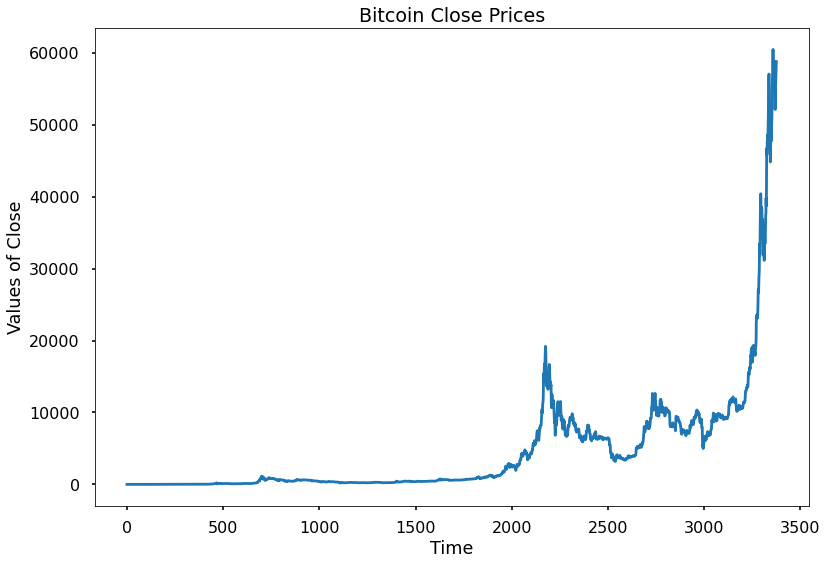

In [65]:
data_plot = grouped_data.loc[:, ["Close"]].values
plt.plot(data_plot)
plt.xlabel("Time")
plt.ylabel("Values of Close")
plt.title("Bitcoin Close Prices")
plt.show()

In [66]:
#we will predict Close values

In [67]:
dataset = df_train.loc[:, ["Close"]].values
dataset.shape

(3207, 1)

In [68]:
#reshape
dataset = dataset.reshape(-1, 1)

#change type
dataset = dataset.astype("float32")
dataset.shape

(3207, 1)

## Scaling Data

In [69]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
data_scaled = scaler.fit_transform(dataset)
data_scaled

array([[7.8616577e-06],
       [2.4757654e-05],
       [3.4834418e-05],
       ...,
       [5.9187502e-01],
       [5.9640354e-01],
       [5.9654176e-01]], dtype=float32)

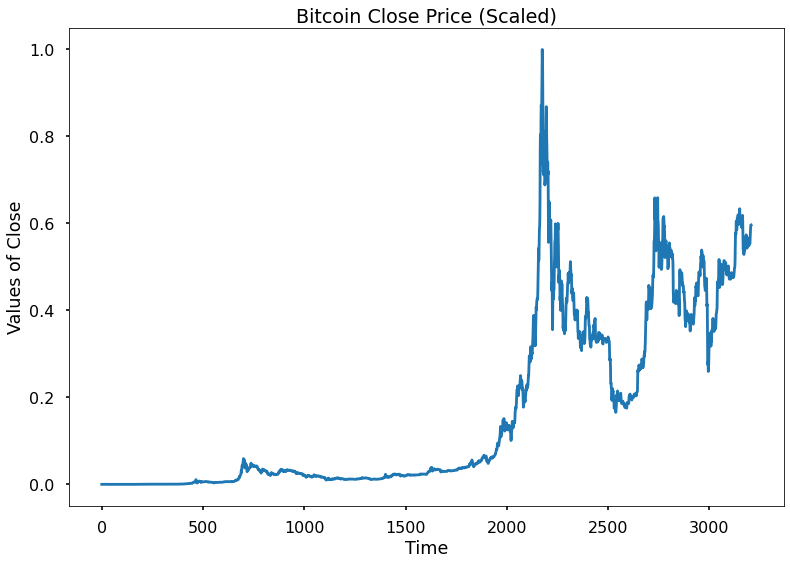

In [70]:
plt.plot(data_scaled)
plt.xlabel("Time")
plt.ylabel("Values of Close")
plt.title("Bitcoin Close Price (Scaled)")
plt.show()

In [71]:
# Creating a data structure with 10 time_step and 1 output
X_train = []
y_train = []
time_step = 10
for i in range(time_step, data_scaled.shape[0]):
    X_train.append(data_scaled[i-time_step:i, 0])
    y_train.append(data_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

X_train shape:  (3197, 10)
y_train shape:  (3197,)


In [72]:
# Reshaping to 3D
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [73]:
print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)

X_train shape:  (3197, 10, 1)
y_train shape:  (3197,)


## Modeling (RNN)

In [74]:
### Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

In [81]:
# Initialising the RNN ( with four layers)
regressor = Sequential()
function = "relu"

# Adding the first RNN layer and some Dropout regularization
regressor.add(SimpleRNN(units = 50, activation=function, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second RNN layer and some Dropout regularization
regressor.add(SimpleRNN(units = 50, activation=function, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third RNN layer and some Dropout regularization
regressor.add(SimpleRNN(units = 50, activation=function, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth RNN layer and some Dropout regularization
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

regressor.summary()

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
# epoch= 100



Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_40 (SimpleRNN)   (None, 10, 50)            2600      
                                                                 
 dropout_40 (Dropout)        (None, 10, 50)            0         
                                                                 
 simple_rnn_41 (SimpleRNN)   (None, 10, 50)            5050      
                                                                 
 dropout_41 (Dropout)        (None, 10, 50)            0         
                                                                 
 simple_rnn_42 (SimpleRNN)   (None, 10, 50)            5050      
                                                                 
 dropout_42 (Dropout)        (None, 10, 50)            0         
                                                                 
 simple_rnn_43 (SimpleRNN)   (None, 50)              

100/100 [==============================] - 1s 6ms/step - loss: 6.9127e-04 - accuracy: 6.2559e-04
Epoch 62/100
100/100 [==============================] - 1s 6ms/step - loss: 7.3588e-04 - accuracy: 6.2559e-04
Epoch 63/100
100/100 [==============================] - 1s 6ms/step - loss: 6.9617e-04 - accuracy: 6.2559e-04
Epoch 64/100
100/100 [==============================] - 1s 6ms/step - loss: 6.9490e-04 - accuracy: 6.2559e-04
Epoch 65/100
100/100 [==============================] - 1s 6ms/step - loss: 8.3706e-04 - accuracy: 6.2559e-04
Epoch 66/100
100/100 [==============================] - 1s 7ms/step - loss: 7.3032e-04 - accuracy: 6.2559e-04
Epoch 67/100
100/100 [==============================] - 1s 6ms/step - loss: 7.3373e-04 - accuracy: 6.2559e-04
Epoch 68/100
100/100 [==============================] - 1s 6ms/step - loss: 7.0158e-04 - accuracy: 6.2559e-04
Epoch 69/100
100/100 [==============================] - 1s 6ms/step - loss: 6.9808e-04 - accuracy: 6.2559e-04
Epoch 70/100
100/100 [=

## Prediction and Visualising RNN MOdel

In [76]:
real_bitcoin_price = df_test.loc[:, ["Close"]].values

In [77]:
real_bitcoin_price.shape

(169, 1)

In [78]:
df_total = pd.concat((df_train['Close'], df_test['Close']), axis = 0)
inputs = df_total[len(df_total) - len(df_test) - time_step:].values.reshape(-1,1)
inputs = scaler.transform(inputs)  # min max scaler

Standardized: 22990.50 (7342.07) MSE


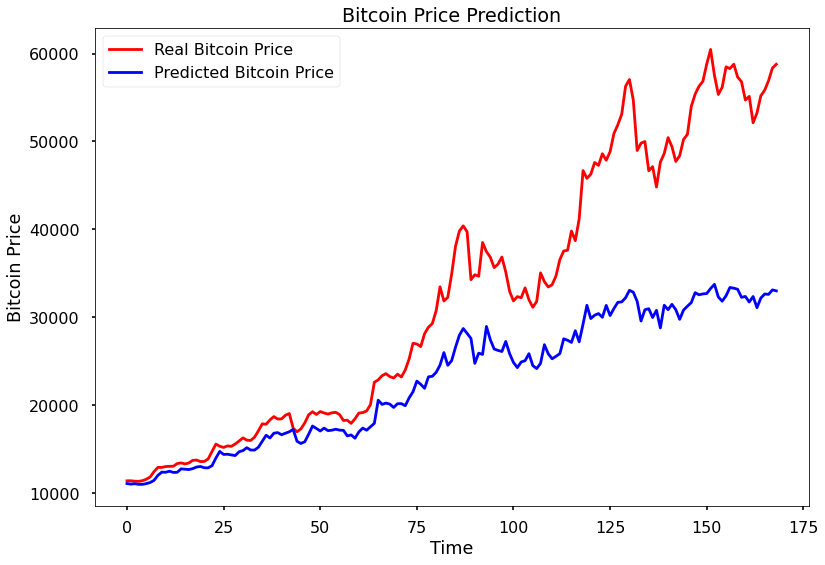

[[11092.007 ]
 [11031.214 ]
 [11077.293 ]
 [11010.89  ]
 [11005.295 ]
 [11085.844 ]
 [11216.81  ]
 [11458.79  ]
 [12034.97  ]
 [12393.315 ]
 [12381.555 ]
 [12497.792 ]
 [12362.183 ]
 [12375.8125]
 [12771.111 ]
 [12729.814 ]
 [12687.587 ]
 [12791.656 ]
 [12976.8125]
 [13039.126 ]
 [12892.197 ]
 [12880.576 ]
 [13130.415 ]
 [13999.98  ]
 [14748.469 ]
 [14405.815 ]
 [14430.626 ]
 [14359.13  ]
 [14278.259 ]
 [14709.608 ]
 [14843.594 ]
 [15171.81  ]
 [14911.088 ]
 [14901.356 ]
 [15223.101 ]
 [15900.228 ]
 [16589.543 ]
 [16280.842 ]
 [16819.828 ]
 [16887.766 ]
 [16649.006 ]
 [16820.38  ]
 [16987.176 ]
 [17252.576 ]
 [15903.174 ]
 [15654.435 ]
 [15849.997 ]
 [16704.68  ]
 [17635.633 ]
 [17366.537 ]
 [17071.49  ]
 [17397.662 ]
 [17112.555 ]
 [17163.94  ]
 [17273.63  ]
 [17171.246 ]
 [17149.96  ]
 [16513.719 ]
 [16624.768 ]
 [16254.    ]
 [16975.361 ]
 [17401.88  ]
 [17163.467 ]
 [17553.44  ]
 [17942.479 ]
 [20582.049 ]
 [20099.783 ]
 [20247.52  ]
 [20130.367 ]
 [19749.947 ]
 [20181.68  ]
 [2018

In [87]:
X_test = []
for i in range(time_step, inputs.shape[0]):
    X_test.append(inputs[i-time_step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_bitcoin_price = regressor.predict(X_test)
predicted_bitcoin_price = scaler.inverse_transform(predicted_bitcoin_price)
print("Standardized: %.2f (%.2f) MSE" % (predicted_bitcoin_price.mean(), predicted_bitcoin_price.std()))



# Visualising the results
plt.plot(real_bitcoin_price, color = 'red', label = 'Real Bitcoin Price')
plt.plot(predicted_bitcoin_price, color = 'blue', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

print(predicted_bitcoin_price)

# Long Short Time Memory (LSTM)

## Importing Libraries

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

## Train and Test Split

In [90]:
# We divide the data by Training %10, Test %10

In [91]:
train_size = int(len(grouped_data) * 0.90)
test_size = len(grouped_data) - train_size
df_train = grouped_data.iloc[0:train_size, :]
df_test = grouped_data.iloc[train_size:len(grouped_data), :]
print("DF_Train size: {}, DF_Test size: {}". format(len(df_train), len(df_test)))

DF_Train size: 3038, DF_Test size: 338


## Visualizing Data

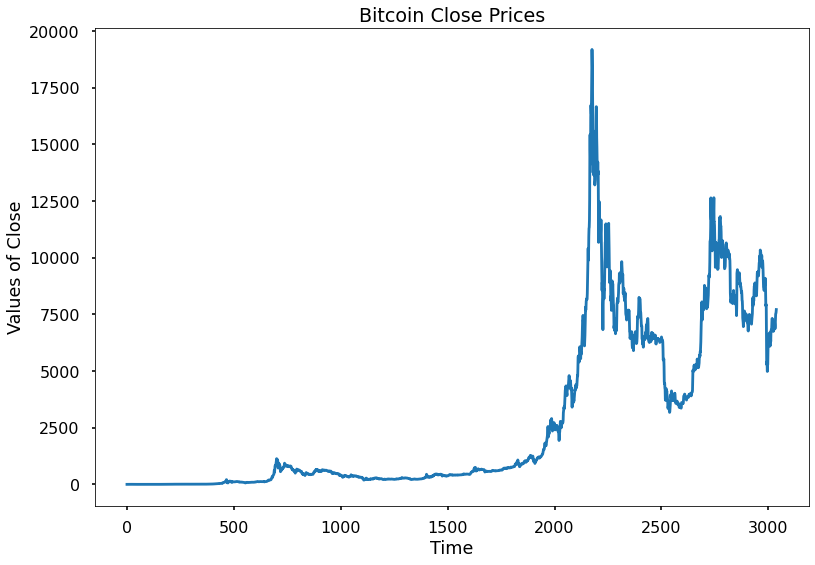

In [92]:
data_plot = df_train.loc[:, ["Close"]].values
plt.plot(data_plot)
plt.xlabel("Time")
plt.ylabel("Values of Close")
plt.title("Bitcoin Close Prices")
plt.show()

In [93]:
#we will predict Close values

In [94]:
dataset = df_train.loc[:, ["Close"]].values
dataset.shape

(3038, 1)

In [95]:
#reshape
dataset = dataset.reshape(-1, 1)

#change type
dataset = dataset.astype("float32")
dataset.shape

(3038, 1)

## Scaling Data

In [96]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
data_scaled = scaler.fit_transform(dataset)

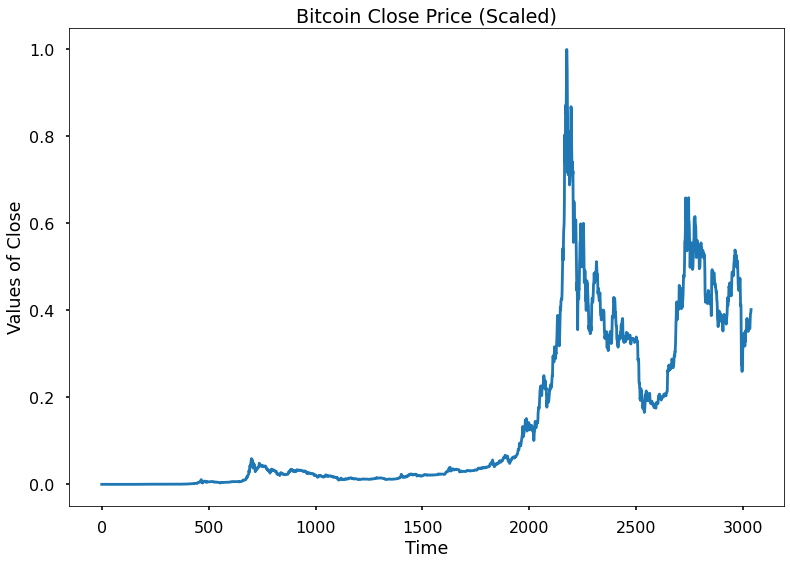

In [97]:
plt.plot(data_scaled)
plt.xlabel("Time")
plt.ylabel("Values of Close")
plt.title("Bitcoin Close Price (Scaled)")
plt.show()

In [98]:
# We divide the DATA_SCALED by Training %50, Test %50
train_size = int(len(data_scaled) * 0.50)
test_size = len(data_scaled) - train_size
data_scaled_train = data_scaled[0:train_size, :]
data_scaled_test = data_scaled[train_size:len(data_scaled), :]

print("data_scaled_train size: {}\ndata_scaled_test size: {}". format(len(data_scaled_train), len(data_scaled_test)))
print("data_scaled_train shape: {}\ndata_scaled_test shape: {}". format(data_scaled_train.shape, data_scaled_test.shape))

data_scaled_train size: 1519
data_scaled_test size: 1519
data_scaled_train shape: (1519, 1)
data_scaled_test shape: (1519, 1)


In [99]:
# Creating a data structure with 10 time_step and 1 output (TRAIN)
time_step = 10
dataX = []
dataY = []
for i in range(len(data_scaled_train) - time_step - 1):
    a = data_scaled_train[i:(i + time_step), 0]
    dataX.append(a)
    dataY.append(data_scaled_train[i + time_step, 0])
trainX = np.array(dataX)
trainY = np.array(dataY)

print("trainX shape: {}\ntrainY shape: {}". format(trainX.shape, trainY.shape))

trainX shape: (1508, 10)
trainY shape: (1508,)


In [100]:
# Creating a data structure with 10 time_step and 1 output (TEST)
dataX = []
dataY = []
for i in range(len(data_scaled_test) - time_step -1):
    a = data_scaled_test[i:(i + time_step), 0]
    dataX.append(a)
    dataY.append(data_scaled_test[i + time_step, 0])
testX = np.array(dataX)
testY = np.array(dataY)

print("testX shape: {}\ntestY shape: {}". format(testX.shape, testY.shape))

testX shape: (1508, 10)
testY shape: (1508,)


In [101]:
# Reshaping to 3D
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print("X_train shape: ",trainX.shape)
print("X_test shape: ",testX.shape)

X_train shape:  (1508, 1, 10)
X_test shape:  (1508, 1, 10)


## Modeling (LSTM)

In [102]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

In [109]:
# model
model = Sequential()
model.add(LSTM(256, input_shape = (1, time_step))) # 256 LSTM neuron(block)
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss= "binary_crossentropy", optimizer = "adam" , metrics=['accuracy'])
model.fit(trainX, trainY, epochs=100, batch_size=16)

Epoch 1/100
95/95 [==============================] - 2s 4ms/step - loss: 0.0748 - accuracy: 6.6313e-04
Epoch 2/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0647 - accuracy: 6.6313e-04
Epoch 3/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0640 - accuracy: 6.6313e-04
Epoch 4/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0641 - accuracy: 6.6313e-04
Epoch 5/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0648 - accuracy: 6.6313e-04
Epoch 6/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0642 - accuracy: 6.6313e-04
Epoch 7/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0641 - accuracy: 6.6313e-04
Epoch 8/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0646 - accuracy: 6.6313e-04
Epoch 9/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0648 - accuracy: 6.6313e-04
Epoch 10/100
95/95 [==============================] - 0s 4ms/step - loss:

95/95 [==============================] - 0s 4ms/step - loss: 0.0642 - accuracy: 6.6313e-04
Epoch 80/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0696 - accuracy: 6.6313e-04
Epoch 81/100
95/95 [==============================] - 0s 5ms/step - loss: 0.0664 - accuracy: 6.6313e-04
Epoch 82/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0652 - accuracy: 6.6313e-04
Epoch 83/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0653 - accuracy: 6.6313e-04
Epoch 84/100
95/95 [==============================] - 0s 5ms/step - loss: 0.0650 - accuracy: 6.6313e-04
Epoch 85/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0647 - accuracy: 6.6313e-04
Epoch 86/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0668 - accuracy: 6.6313e-04
Epoch 87/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0649 - accuracy: 6.6313e-04
Epoch 88/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0

In [105]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               273408    
                                                                 
 dropout_46 (Dropout)        (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 273,665
Trainable params: 273,665
Non-trainable params: 0
_________________________________________________________________


## Prediction and Visulazation

In [106]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY_ = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_ = scaler.inverse_transform([testY])

# calculate root mean squared error
trainscore = math.sqrt(mean_squared_error(trainY_[0], trainPredict[:, 0]))
print("Train Score: %.2f RMSE" % (trainscore))
testscore = math.sqrt(mean_squared_error(testY_[0], testPredict[:, 0]))
print("Test Score: %.2f RMSE" % (testscore))

Train Score: 31.53 RMSE
Test Score: 2021.81 RMSE


No handles with labels found to put in legend.


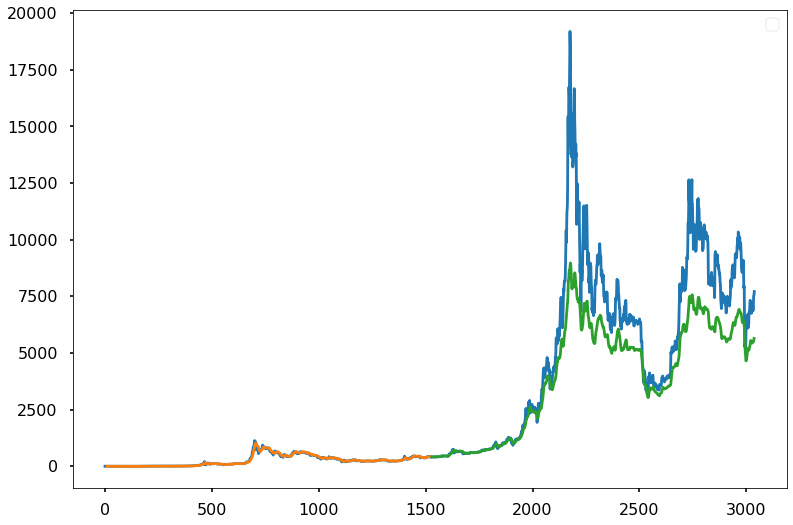

In [107]:
# shifting train
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(trainPredict) + time_step, :] = trainPredict
# shifting test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (time_step * 2) + 1:len(data_scaled) - 1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
#plt.xlim(2500,3200)
plt.legend()
plt.show()

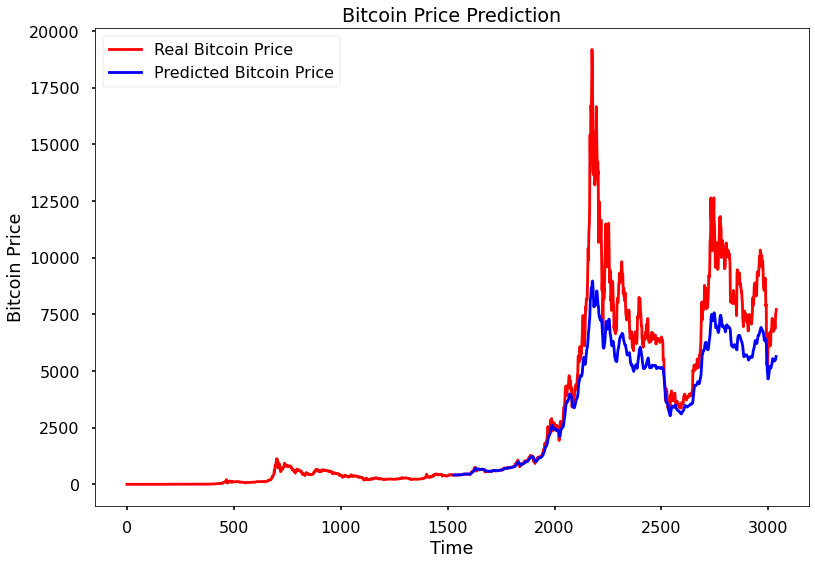

In [108]:
# Visualising the results
plt.plot(scaler.inverse_transform(data_scaled), color = 'red', label = 'Real Bitcoin Price')
plt.plot(testPredictPlot, color = 'blue', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()